In [62]:
import sys
sys.path.append('../src/') # for graph_data

import graph_data as gd
import time
import torch
from models import TreeSupport
from torch import optim
from torch.nn import BCELoss
from torch.utils.data import random_split, ConcatDataset
from torch_geometric.data import DataLoader
from Bio import Phylo as phy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('text', usetex=True)

torch.manual_seed(245)

# Datasets
## Prepare trees and reconstructed sequences

In [63]:
data_path = '../data/'

In [77]:
target_tree = phy.read(data_path+'tree/Fungi45_infer/Fungi.tre', 'newick')
#all_data = gd.Trees.load_ready_trees(data_path+'tree/Fungi45_infer/fml_output/', data_path+'tree/Fungi45_infer/fml_output/*.tre', target_tree)  # INITIALIZE NEW DS
fungi_data = gd.Trees(data_path+'tree/Fungi45_infer/', data_path+'alns/Fungi45/', target_tree)

# get binned values
l = list()
for d in fungi_data:
    nodes = torch.stack(torch.unique(d.edge_index[0], return_counts=True))
    internodes = nodes[0, nodes[1]!=1]
    l += d.y[internodes].squeeze().tolist()
med = np.median(l)
fungi_data.data.y = (fungi_data.data.y > med).long()
fungi_data.data.x = fungi_data.data.x.float()
fungi_data.data.edge_attr = (torch.max(fungi_data.data.edge_attr)+0.001 - fungi_data.data.edge_attr).float()
fungi_data.data.edge_index = fungi_data.data.edge_index.long()

In [78]:
target_tree = phy.read(data_path+'tree/Archaea/Archaea.tre', 'newick')
#archaea_data = gd.Trees.load_ready_trees(data_path+'tree/Archaea/fml_output/', data_path+'tree/Archaea/fml_output/*.tre', target_tree)  # INITIALIZE NEW DS //delete temp_tree
archaea_data = gd.Trees(data_path+"tree/Archaea/", data_path+"alns/Archaea/", target_tree)

# get binned values
l = list()
for d in archaea_data:
    nodes = torch.stack(torch.unique(d.edge_index[0], return_counts=True))
    internodes = nodes[0, nodes[1]!=1]
    l += d.y[internodes].squeeze().tolist()
med = np.median(l)
archaea_data.data.y = (archaea_data.data.y > med).long()
archaea_data.data.x = archaea_data.data.x.float()
archaea_data.data.edge_attr = (torch.max(archaea_data.data.edge_attr)+0.001 - archaea_data.data.edge_attr).float()
archaea_data.data.edge_index = archaea_data.data.edge_index.long()

In [79]:
# concatenate datasets
all_data =  ConcatDataset([fungi_data, archaea_data])

In [80]:
# data preparation
train_batch = 50
test_batch = 50
# data loaders
train, test = random_split(
    all_data, [round(len(all_data) * 0.8), round(len(all_data) * 0.2)]
)

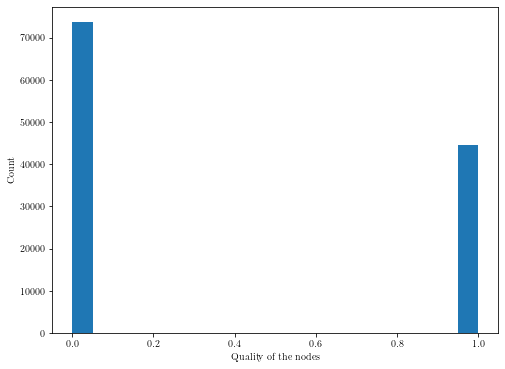

In [81]:
lst = list()
for i, data in enumerate(train):
    nodes = torch.stack(torch.unique(data.edge_index[0], return_counts=True))
    internodes = nodes[0, nodes[1]!=1]
    lst += data.y[internodes].squeeze().tolist()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
plt.hist(lst, bins=20)
ax.set_xlabel('Quality of the nodes')
ax.set_ylabel('Count')
plt.savefig('quality.png')

In [82]:
train_dl = DataLoader(
    train, batch_size=train_batch, pin_memory=True, num_workers=3
)
test_dl = DataLoader(
    test, batch_size=test_batch, num_workers=2
)

In [76]:
model = TreeSupport(231, 400)
model = model.cuda()
silent = False
num_epochs = 400
loss_fn = BCELoss()
test_batches = len(test_dl)
# stattr
losses = []
val_losses = []
learning_rates = []

In [10]:
# interactive descending lr for less loss
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, verbose=True, cooldown=2, patience=5
)
start = time.time()
for epoch in range(num_epochs):
    model.train()
    for data in train_dl:
        data = data.to(torch.device('cuda'))
        optimizer.zero_grad()
        out = model(data)
        loss = loss_fn(out, data.y)
        losses.append(loss.item())  # history
        # optimize
        loss.backward()
        optimizer.step()

        # stats
        learning_rates.append(-1)

    # evaluation
    model.eval()
    agg_loss = 0
    with torch.autograd.no_grad():
        for data in test_dl:
            data = data.to(torch.device('cuda'))
            out = model(data)
            agg_loss += loss_fn(out, data.y)
        val_losses.append(agg_loss.item()/test_batches)
    scheduler.step(agg_loss)
    if not silent:
        print(
            "Epoch [{}/{}], Loss (last training batch/val): {:.4f}/{:.4f}. Time elapsed: {:.2f}".format(
                epoch + 1,
                num_epochs,
                losses[-1],
                val_losses[-1],
                time.time() - start,
            )
        )

Epoch [1/400], Loss (last training batch/val): 0.2483/0.2479. Time elapsed: 3.20
Epoch [2/400], Loss (last training batch/val): 0.2466/0.2459. Time elapsed: 6.19
Epoch [3/400], Loss (last training batch/val): 0.2431/0.2427. Time elapsed: 8.61
Epoch [4/400], Loss (last training batch/val): 0.2352/0.2349. Time elapsed: 11.62
Epoch [5/400], Loss (last training batch/val): 0.2185/0.2187. Time elapsed: 13.86
Epoch [6/400], Loss (last training batch/val): 0.1956/0.1946. Time elapsed: 16.55
Epoch [7/400], Loss (last training batch/val): 0.1760/0.1772. Time elapsed: 18.95
Epoch [8/400], Loss (last training batch/val): 0.1593/0.1598. Time elapsed: 21.76
Epoch [9/400], Loss (last training batch/val): 0.1452/0.1382. Time elapsed: 24.40
Epoch [10/400], Loss (last training batch/val): 0.1298/0.1275. Time elapsed: 27.14
Epoch [11/400], Loss (last training batch/val): 0.1234/0.1208. Time elapsed: 29.58
Epoch [12/400], Loss (last training batch/val): 0.1186/0.1091. Time elapsed: 31.82
Epoch [13/400], 

# Learning stats

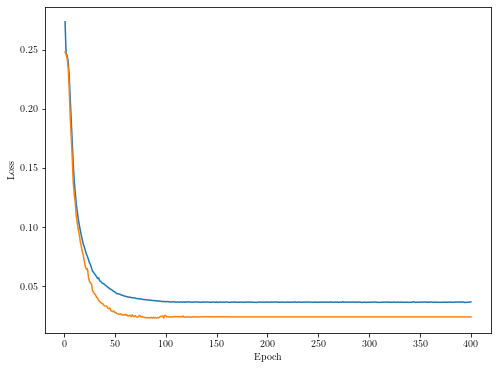

In [11]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

plt.plot(
    range(1, len(val_losses)+1), 
    list(map(
        lambda i: np.mean(losses[i:i+len(train_dl)]),
        range(0, len(losses)-len(train_dl)+1, len(train_dl))
    ))
)
plt.plot(range(1, len(val_losses)+1), val_losses)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.savefig('loss.png')

In [12]:
torch.save(model.state_dict(), '../models/NewTry2.dct')

## Test with completely different data

In [13]:
from sklearn import metrics

In [14]:
# data
target_tree = phy.read(data_path+'tree/Other_eukaryota_2018.tre', 'newick')
test_dataset = gd.Trees(
    data_path+"tree/Eukaryota/",
    data_path+"alns/other_eukaryota_2018/",
    target_tree
)
# transform to feed into the model
test_dataset.data.x = test_dataset.data.x.float()
test_dataset.data.edge_attr = (torch.max(test_dataset.data.edge_attr)+0.001 - test_dataset.data.edge_attr).float()
test_dataset.data.edge_index = test_dataset.data.edge_index.long()
test_dl = DataLoader(
    test_dataset, batch_size=test_batch, num_workers=2
)

In [15]:
nplist = list()
for data in test_dl:
    with torch.no_grad():
        data.x, data.edge_index, data.edge_attr = data.x.float(), data.edge_index.long(), data.edge_attr.float()  # CLEAN IT!!!!!
        out = model(data.to(torch.device('cuda')))
        nodes = torch.stack(torch.unique(data.edge_index[0], return_counts=True))
        internodes = nodes[0, nodes[1]!=1]
        nplist.append(np.concatenate([data.y[internodes].cpu().numpy(), out[internodes].detach().cpu().numpy()], axis=1))
test_results = pd.DataFrame(np.concatenate(nplist, 0), columns=['actual', 'predicted'])
test_results.describe()

,actual,predicted
count,1.340500e+05,134050.000000
mean,5.657991e-03,0.092838
std,5.977007e-02,0.171863
min,1.925930e-34,-0.000314
25%,5.960464e-08,-0.000106
50%,6.103516e-05,-0.000030
75%,9.765625e-04,0.076912
max,1.000000e+00,1.109409


In [16]:
test_results = pd.DataFrame(np.concatenate(nplist), columns=['actual', 'predicted'])

# Further assessment

ROC 

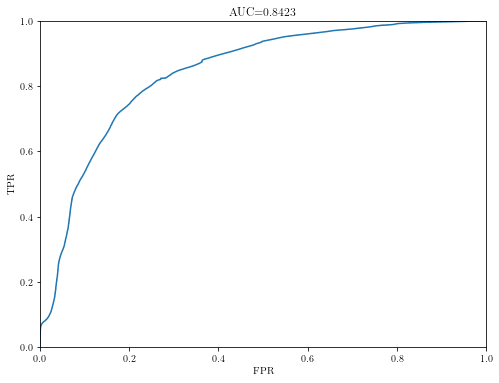

In [19]:
thr = test_results["actual"].median()
fpr, tpr, thresholds_roc = metrics.roc_curve(test_results["actual"]>=thr, test_results["predicted"])

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

plt.plot(fpr, tpr)
plt.title('AUC={:.4f}'.format(metrics.roc_auc_score(test_results["actual"]>=thr, test_results["predicted"])))
plt.xlim(0, 1)
plt.ylim(0, 1)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.savefig('roc.png')

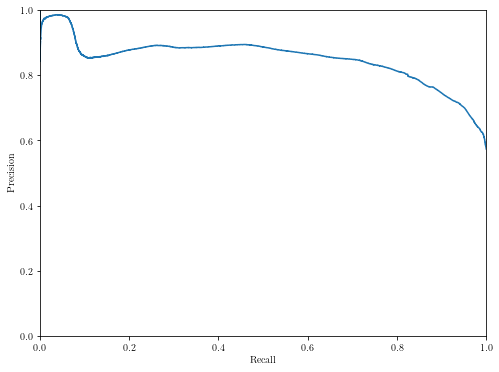

In [20]:
prec, rec, thresholds_recprec = metrics.precision_recall_curve(test_results["actual"]>=thr, test_results["predicted"])
roc_data = pd.DataFrame({"Precision": prec, "Recall": rec})
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

plt.plot(rec, prec)
plt.xlim(0, 1)
plt.ylim(0, 1)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
plt.savefig('recprec.png')

In [21]:
optimal_thr = thresholds_roc[np.argmax(tpr-fpr)]

In [22]:
optimal_thr

-5.328967e-05

In [25]:
metrics.confusion_matrix(test_results["actual"]>=thr, test_results["predicted"]>=optimal_thr)

array([[42398, 14883],
       [14231, 62538]])

In [26]:
fpr[np.argmax(tpr-fpr)]

0.2598243745744662

In [27]:
tpr[np.argmax(tpr-fpr)]

0.8146256952676211

In [ ]:
np.quantile(.data.y[], 0.5)

In [ ]:
for d in archaea_data:
    nodes = torch.stack(torch.unique(d.edge_index[0], return_counts=True))
    internodes = nodes[0, nodes[1]!=1]
    d.y[internodes]

In [ ]:
med

In [ ]:
internodes

In [ ]:
np.quantile(d.y.squeeze(), [0.25, 0.5, 0.75])

In [ ]:
torch.mean(archaea_data.data.y.float())

1.0

In [60]:
for d in archaea_data:
    nodes = torch.stack(torch.unique(d.edge_index[0], return_counts=True))
    internodes = nodes[0, nodes[1]!=1]
    d.y[internodes]

In [88]:
med

1.734723475976807e-18

In [51]:
internodes

tensor([ 0,  1,  4,  5,  7,  8,  9, 10, 11, 12, 13, 19, 22, 23, 27, 30, 31, 33,
        34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 51, 54, 57, 61, 63,
        70, 72, 76, 77, 78, 79, 83])

In [56]:
np.quantile(d.y.squeeze(), [0.25, 0.5, 0.75])

array([1.73472348e-18, 1.00000000e+00, 1.00000000e+00])

In [87]:
torch.mean(archaea_data.data.y.float())

tensor(0.6796)